In [2]:
from functools import partial

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from collections import namedtuple

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from modules.dataset import read_cacm_docs, read_queries
from modules.evaluation import read_qrels
from modules.preprocessing import load_stopwords, process_text

from modules.ranking import compute_df
from modules.indexing import build_tf_index

from modules.utils import print_results

from modules.dataset import Dataset

from modules.ranking import tfidf_search, naive_ql_search, ql_search, bm25_search

from modules.evaluation import precision_k, recall_k, average_precision, evaluate_search_fn

In [4]:
# Download the Dataset if you have not done it already!
from modules.utils import download_dataset

download_dataset()

---
## Section 5 Analysis <a class="anchor" id="analysis"></a>

### 5.1: Information Retrieval Axioms

In the first analysis section we will explore different Information Retrieval Axioms by using your implementations from above. This section can be a good way to:
1. Learn/Remember the most important IR concepts
2. Check your implementations of the search functions you implemented above,
3. Expand your understanding regarding the traditional/statistical IR approaches and the way of evaluating them.

Note that each for the questions below we expect a very short answer of about a couple of sentences (max 75 words).
Please answer the question highlighted with red color as: *<font color='red'>Question</font>*, and move the answers to the [analysis.md](analysis.md).

In [5]:
# Load the documents of the dataset again and the stopwords
docs = read_cacm_docs()
n_docs = len(docs)
stopwords = load_stopwords()

config = {
  "stem": True,
  "remove_stopwords" : True,
  "lowercase_text": True,
}

def get_dataset(docs, stopwords, config=config):
    """
    Returns ta dataset based on the documents given, the stopwrods,
    and the preprocessing configurations.
    """
    doc_repr = []
    n_docs = len(docs)
    for (doc_id, document) in docs:
        doc_repr.append((doc_id, process_text(document, stopwords, **config)))

    tf_index = build_tf_index(doc_repr)
    df = compute_df([d[1] for d in doc_repr])


    docs_by_id = dict(docs)
    dh = Dataset(n_docs, docs_by_id, doc_repr,
                df, tf_index,
                stopwords, config)
    return dh

def get_docs(doc_ids, all_docs=docs):
    """
    Returns a subset of the documents based on the selected
    document ids.
    """
    all_docs_by_id = dict(all_docs)

    return [(did, all_docs_by_id[did]) for did in doc_ids]

#### 5.1: Evaluating Rankings Axioms (ERA)
In this subsection we will explore the some of the evaluation axioms in IR

In [6]:
def print_scores(ranking, k):
    """
    Helper method for printing the scores for a ranking.
    """
    precision = precision_k(ranking, set(qrels_11), k)
    print(f'precision@{k} = {precision}')

    recall = recall_k(ranking, set(qrels_11), k)
    print(f'recall@{k} = {recall}')

    mean_ap = average_precision(ranking, set(qrels_11))
    print(f'MAP = {mean_ap}')

In [7]:
# Define the example ground truth we will be working with
q = 'What articles exist which deal with TSS (Time Sharing System), an\noperating system for IBM computers?'
# we assume we have only 9 documents in our whole datasetfor the query above their qrels below have the first 5 documents as relevant and the last 5 as irrelevant documents.
qrels_11 = ['2358', '2020', '1410', '1605', '1572']      # the relevant documents for the qery
irrelevant_documents_11 = ['1831', '2651', '950', '2664', '2290']  # the irrelevant documents for the query
docs_11_ids = [*qrels_11, *irrelevant_documents_11]        # all the documents are just the intersection of the relevant and irrelevant for the query documents
docs_11 = get_docs(docs_11_ids)
docs_11_by_id = dict(docs_11)

dh_11 = get_dataset(docs_11, stopwords)

Assume we have the following ideal raning for the query above.

In [8]:
# Prepare the Ideal Ranking

# an ideal ranking should approximately have the first 5 relevant documents as they appear below in the top 
# followed by the irrelevant documents.
scores_11 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
gt_ranking_11 = [(did, score) for did, score in zip(docs_11_ids, scores_11)]
print('1.1 - Assumed Ideal Ranking')
print_results(gt_ranking_11, docs_11_by_id)

1.1 - Assumed Ideal Ranking
Rank 0(1.0): The Multics Virtual Memory: Concepts and Design\nA...
Rank 1(1.0): The Allocation of Computer Resources-Is Pricing th...
Rank 2(1.0): Interarrival Statistics for Time Sharing Systems\n...
Rank 3(1.0): An Experimental Comparison of Time Sharing and Bat...
Rank 4(1.0): The Simulation of Time sharing Systems\nThe develo...
Rank 5(0.0): A Comment on Optimal Tree Structures...
Rank 6(0.0): The Treatment of Data Types in EL1\nIn constructin...
Rank 7(0.0): Parallel Methods for Integrating Ordinary Differen...
Rank 8(0.0): Parallelism in Tape-Sorting\nTwo methods for emplo...
Rank 9(0.0): Immediate Predominators in a Directed Graph [H] (A...


In [9]:
print('> Evaluation scores for the ideal ranking:')
print_scores(gt_ranking_11, k=5)

> Evaluation scores for the ideal ranking:
precision@5 = 1.0
recall@5 = 1.0
MAP = 1.0


##### 5.1.1: ERA - Ranking Swap Impact (RSI)

1. Assume we are given from a ranking method the following ranking `RSI-1`.

In [10]:
doc_ids_11_a1_1 = ['2358', '2664', '2020', '1410', '2290', '1605', '1572', '1831', '2651', '950'] 
scores_11_a1_1 = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
ranking_11_a1_1 = [(did, score) for did, score in zip(doc_ids_11_a1_1, scores_11_a1_1)]
print('The Ranking of RSI-1:')
print_results(ranking_11_a1_1, docs_11_by_id)
print()
print('> Evaluation scores for RSI-1:')
print_scores(ranking_11_a1_1, k=len(qrels_11))

The Ranking of RSI-1:
Rank 0(1.0): The Multics Virtual Memory: Concepts and Design\nA...
Rank 1(0.9): Parallelism in Tape-Sorting\nTwo methods for emplo...
Rank 2(0.8): The Allocation of Computer Resources-Is Pricing th...
Rank 3(0.7): Interarrival Statistics for Time Sharing Systems\n...
Rank 4(0.6): Immediate Predominators in a Directed Graph [H] (A...
Rank 5(0.5): An Experimental Comparison of Time Sharing and Bat...
Rank 6(0.4): The Simulation of Time sharing Systems\nThe develo...
Rank 7(0.3): A Comment on Optimal Tree Structures...
Rank 8(0.2): The Treatment of Data Types in EL1\nIn constructin...
Rank 9(0.1): Parallel Methods for Integrating Ordinary Differen...

> Evaluation scores for RSI-1:
precision@5 = 0.6
recall@5 = 0.6
MAP = 0.7595238095238095


2. Now assume that as an improvement to the ranking method above, another method attempts to improve the results and returns the following ranking named ``RSI-2`` as an improvement to the initial one (`RSI-1`):

In [11]:
# RSI-1: ['2358', '2664', '2020', '1410', '2290', '1605', '1572', '1831', '2651', '950'] 
# RSI-2: ['2358', '2664', '2020', '1410', '1605', '2290', '1572', '1831', '2651', '950'] 
doc_ids_11_a1_2 = ['2358', '2664', '2020', '1410', '1605', '2290', '1572', '1831', '2651', '950'] 
scores_11_a1_2 = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
ranking_11_a1_2 = [(did, score) for did, score in zip(doc_ids_11_a1_2, scores_11_a1_2)]
print('> The Ranking of RSI-2:')
print_results(ranking_11_a1_2, docs_11_by_id)
print()
print('> Evaluation scores for RSI-2:')
print_scores(ranking_11_a1_2, k=len(qrels_11))

> The Ranking of RSI-2:
Rank 0(1.0): The Multics Virtual Memory: Concepts and Design\nA...
Rank 1(0.9): Parallelism in Tape-Sorting\nTwo methods for emplo...
Rank 2(0.8): The Allocation of Computer Resources-Is Pricing th...
Rank 3(0.7): Interarrival Statistics for Time Sharing Systems\n...
Rank 4(0.6): An Experimental Comparison of Time Sharing and Bat...
Rank 5(0.5): Immediate Predominators in a Directed Graph [H] (A...
Rank 6(0.4): The Simulation of Time sharing Systems\nThe develo...
Rank 7(0.3): A Comment on Optimal Tree Structures...
Rank 8(0.2): The Treatment of Data Types in EL1\nIn constructin...
Rank 9(0.1): Parallel Methods for Integrating Ordinary Differen...

> Evaluation scores for RSI-2:
precision@5 = 0.8
recall@5 = 0.8
MAP = 0.7861904761904762


3. In addition to the first improvement above (`RSI-2`), another ranking method returns the following ranking named `RSI-3` as an alternative improvement to the `RSI-2`:

In [12]:
# RSI-1: ['2358', '2664', '2020', '1410', '2290', '1605', '1572', '1831', '2651', '950'] 
# RSI-2: ['2358', '2664', '2020', '1410', '1605', '2290', '1572', '1831', '2651', '950']
# RSI-3: ['2358', '2020', '2664', '1410', '2290', '1605', '1572', '1831', '2651', '950'] 
doc_ids_11_a1_3 = ['2358', '2020', '2664', '1410', '2290', '1605', '1572', '1831', '2651', '950'] 
scores_11_a1_3 = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
ranking_11_a1_3 = [(did, score) for did, score in zip(doc_ids_11_a1_3, scores_11_a1_3)]
print('> The Ranking of RSI-3:')
print_results(ranking_11_a1_3, docs_11_by_id)
print()
print('> Evaluation scores for RSI-3:')
print_scores(ranking_11_a1_3, k=len(qrels_11))

> The Ranking of RSI-3:
Rank 0(1.0): The Multics Virtual Memory: Concepts and Design\nA...
Rank 1(0.9): The Allocation of Computer Resources-Is Pricing th...
Rank 2(0.8): Parallelism in Tape-Sorting\nTwo methods for emplo...
Rank 3(0.7): Interarrival Statistics for Time Sharing Systems\n...
Rank 4(0.6): Immediate Predominators in a Directed Graph [H] (A...
Rank 5(0.5): An Experimental Comparison of Time Sharing and Bat...
Rank 6(0.4): The Simulation of Time sharing Systems\nThe develo...
Rank 7(0.3): A Comment on Optimal Tree Structures...
Rank 8(0.2): The Treatment of Data Types in EL1\nIn constructin...
Rank 9(0.1): Parallel Methods for Integrating Ordinary Differen...

> Evaluation scores for RSI-3:
precision@5 = 0.6
recall@5 = 0.6
MAP = 0.8261904761904761


*<font color='red'>Question RSI:</font> For each improvement (`RSI-2` and `RSI-3`) what is the minimum number of swaps (i.e., swapping the position of two elements in the ranking) were applied with respect to the initial ranking (`RSI-1`)? Which of the two improvement rankings (`RSI-2` or `RSI-3`) is better and why?* 

*<font color='yellow'>Answer RSI: Please move the answer to the [analysis.md](analysis.md) file.</font>*

RSI-1 and RSI-2 differ by 1 swap. RSI-1 and RSI-3 also differ by 1 swap.

RSI-2 has a higher number of guessed positive predictions (precision), as well as better ratio of correctly guessed positives out of all true positives (recall). The MAP calculates the precision across different relevance thresholds. The better method depends on our purposes. In this specific scenario, we mainly care about having correct guesses along the first 5 predictions, therefore RSI-2 is the superior method.

##### 5.1.2: ERA - Ranking Swap Preference (RSP)

The worst ranking can be derived by placing all the relevant documents at the end of the ranking `RSP-1`, like the ranking below:

In [13]:
doc_ids_11_a2_1 = [ '1831', '2651', '950', '2664', '2290', '2358', '2020', '1410', '1605', '1572']
scores_11_a2_1 = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
ranking_11_a2_1 = [(did, score) for did, score in zip(doc_ids_11_a2_1, scores_11_a2_1)]
print('> The Ranking of RSP-1:')
print_results(ranking_11_a2_1, docs_11_by_id)
print()
print('> Evaluation scores for RSP-1:')
print_scores(ranking_11_a2_1, k=len(qrels_11))

> The Ranking of RSP-1:
Rank 0(1.0): A Comment on Optimal Tree Structures...
Rank 1(0.9): The Treatment of Data Types in EL1\nIn constructin...
Rank 2(0.8): Parallel Methods for Integrating Ordinary Differen...
Rank 3(0.7): Parallelism in Tape-Sorting\nTwo methods for emplo...
Rank 4(0.6): Immediate Predominators in a Directed Graph [H] (A...
Rank 5(0.5): The Multics Virtual Memory: Concepts and Design\nA...
Rank 6(0.4): The Allocation of Computer Resources-Is Pricing th...
Rank 7(0.3): Interarrival Statistics for Time Sharing Systems\n...
Rank 8(0.2): An Experimental Comparison of Time Sharing and Bat...
Rank 9(0.1): The Simulation of Time sharing Systems\nThe develo...

> Evaluation scores for RSP-1:
precision@5 = 0.0
recall@5 = 0.0
MAP = 0.3543650793650793


Imagine you are trying to build a new ranking method, and to do that you are exploring the atributes of good rankings. 

To understand better the importance of the relevant documents at specific positions in a ranking, you explore the effects of changing their positions in it as we have seen in the previous subsection. More specifically, you consider the following scenario: 
* If you are allowed to shift relevant documents in the ranking ***k* times** (where you shift a document higher in the ranking by jumping over documents in front of them) then what would be a good shift strategy? Which documents to push higher in the ranking and how many hops further each of them to take? 

Practically, to be able to put this analysis into practice you start from the worst case scenario (`RSP-1`) mentioned above and you explore two cases each of which you make a total of 9 shifts / hops for relevant documents:

1. First case (`RSP-2`):

In [14]:
# RSP-1: ['1831', '2651', '950', '2664', '2290', '2358', '2020', '1410', '1605', '1572']
# RSP-2: ['1831', '2651', '2358', '2020', '1410', '950', '2664', '2290', '1605', '1572']

# RSP-2 has moved 3 relevant documents up with 3 positions.

doc_ids_11_a2_2 = ['1831', '2651', '2358', '2020', '1410', '950', '2664', '2290', '1605', '1572']
scores_11_a2_2 = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
ranking_11_a2_2 = [(did, score) for did, score in zip(doc_ids_11_a2_2, scores_11_a2_2)]
print('> The Ranking of RSP-2:')
print_results(ranking_11_a2_2, docs_11_by_id)
print()
print('> Evaluation scores for RSP-2:')
print_scores(ranking_11_a2_2, k=len(qrels_11))

['2358', '2020', '1410', '1605', '1572']
> The Ranking of RSP-2:
Rank 0(1.0): A Comment on Optimal Tree Structures...
Rank 1(0.9): The Treatment of Data Types in EL1\nIn constructin...
Rank 2(0.8): The Multics Virtual Memory: Concepts and Design\nA...
Rank 3(0.7): The Allocation of Computer Resources-Is Pricing th...
Rank 4(0.6): Interarrival Statistics for Time Sharing Systems\n...
Rank 5(0.5): Parallel Methods for Integrating Ordinary Differen...
Rank 6(0.4): Parallelism in Tape-Sorting\nTwo methods for emplo...
Rank 7(0.3): Immediate Predominators in a Directed Graph [H] (A...
Rank 8(0.2): An Experimental Comparison of Time Sharing and Bat...
Rank 9(0.1): The Simulation of Time sharing Systems\nThe develo...

> Evaluation scores for RSP-2:
precision@5 = 0.6
recall@5 = 0.6
MAP = 0.47555555555555545


2. Second Case (`RSP-3`):

In [15]:
# RSP-1: ['1831', '2651', '950', '2664', '2290', '2358', '2020', '1410', '1605', '1572']
# RSP-3: ['1572', '1831', '2651', '950', '2664', '2290', '2358', '2020', '1410', '1605']

# RSP-3 has moved only one relevant document up with 9 positions.

doc_ids_11_a2_3 = ['1572', '1831', '2651', '950', '2664', '2290', '2358', '2020', '1410', '1605']
scores_11_a2_3 = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
ranking_11_a2_3 = [(did, score) for did, score in zip(doc_ids_11_a2_3, scores_11_a2_3)]
print('> The Ranking of 5.1.1-2 ranking 3')
print_results(ranking_11_a2_3, docs_11_by_id)
print()
print('> Evaluation scores for 5.1.1-2 ranking 3:')
print_scores(ranking_11_a2_3, k=len(qrels_11))

> The Ranking of 5.1.1-2 ranking 3
Rank 0(1.0): The Simulation of Time sharing Systems\nThe develo...
Rank 1(0.9): A Comment on Optimal Tree Structures...
Rank 2(0.8): The Treatment of Data Types in EL1\nIn constructin...
Rank 3(0.7): Parallel Methods for Integrating Ordinary Differen...
Rank 4(0.6): Parallelism in Tape-Sorting\nTwo methods for emplo...
Rank 5(0.5): Immediate Predominators in a Directed Graph [H] (A...
Rank 6(0.4): The Multics Virtual Memory: Concepts and Design\nA...
Rank 7(0.3): The Allocation of Computer Resources-Is Pricing th...
Rank 8(0.2): Interarrival Statistics for Time Sharing Systems\n...
Rank 9(0.1): An Experimental Comparison of Time Sharing and Bat...

> Evaluation scores for 5.1.1-2 ranking 3:
precision@5 = 0.2
recall@5 = 0.2
MAP = 0.5210317460317461


*<font color='red'>Question RSP:</font> How many relevant documents are shifted in each ranking (`RSP-2` or `RSP-3`), with respect to the worst case ranking `RSP-1`? Which of the two rankings is better and how do you justify it? What general observation/conclusion can you make regarding the move/shift of relevant documents in the ranking?*

*<font color='yellow'>Answer RSP: Please move the answer to the [analysis.md](analysis.md) file.</font>*

RSP-2 has shifted a group of 3 relevant documents each with 3 positions up relatively to RSP-1, while RSP-3 has shifted a single relevant document up 9 positions.

In the first scheme, we move more relevant results up, which might be good in smaller rankings (e.g. here it's just 10 results) and leads to better recall@5, but imagine Google returning 10000 results, and we move 1000 relevant results up by 10 positions -- the results would still be horrible. In the second scheme, we move a single relevant result to the top, which might be a much better strategy in larger rankings. 
If we have no information about the relevance of the documents and we are dealing with usually small result sets, however, RSP-2 could, potentially, on average, be better.

---
#### Subsection 5.2: Analyzing the Retrieval Constraints (ARC)
In this subsection we will explore some of the axioms for basic Retrieval Models in IR using the TF-IDF method.

In this section we ask you to implement two different tf-idf ranking methods:

1. The `count-idf1`:

$$ TF=f_{d,t} $$

$$ IDF=\log (\frac{N}{n_t})$$

2. The `double normalization-tf`:

$$ TF=(k + k \frac{f_{d,t}}{max_t f_{d,t}}) $$

$$ IDF=\log (\frac{N}{n_t})$$

where $f_{d,t}$ is the frequency of token $t$ in document $d$, $N$ is the number of total documents and $n_t$ is the number of documents containing token $t$.

**Note**: Although, we will not explicitly test the other two tf-idf ranking methods we ask you above, you should implement them yourself so that to understand how they work since you will need to investigate them further in the next questions. In addition to what said, although we will not explicitly test these notebooks and your implementations we may look into the code to check that you have actually implemented yourself.

You do have the freedom though to implement them as you want. The only thing we ask is that they should follow the same method signature (i.e., method API) as the definition of the `tfidf_search` in the modules [ranking.py](./modules/ranking.py) module (but you are very flexible and allowed to use more parameters and maybe default them to other values, or use partial to fill the method's parameters to make the method's API as required). That is to say, the parameters are expected to be: first the `query`, and then the `dh` of type `Dataset`.

You can implement them here in the notebook or in a different module and then import them here.

*<font color='yellow'>Your implementation or imports in the next code block.</font>*

In [16]:
# Import your implementations or implement them here
# import ...
# TODO: Complete this part of the code

# Using integrated math functions is actually faster than using numpy for small cases and especially when not dealing with matrices.
from math import log


def count_idf_score(tf, tdf, n_docs):
    """
    Returns the score for the naive count-based tf-idf search function.
    """
    return tf * log(n_docs / tdf)


def count_idf_search(query: str, dh: Dataset):
    """
    Returns the number of documents that are retrieved by the search function
    that are in the ideal ranking.
    """
    processed_query = dh.preprocess_query(query)
    n_docs = dh.n_docs
    tf_index = dh.get_index()
    df = dh.get_df()
    scores = {}
    for term in processed_query:
        for doc_id, tf in tf_index.get(term, []):
            if doc_id not in scores:
                scores[doc_id] = 0
            scores[doc_id] += count_idf_score(tf, df[term], n_docs)

    return sorted(scores.items(), key=lambda x: x[1], reverse=True)


def double_normalization_score(tf, max_tf, tdf, n_docs, k=0.5):
    """
    Returns the tf component from the double normalization search function.
    """
    return (k + (k) * (tf / max_tf)) * log(n_docs / tdf)


def double_normalization_idf_search(query: str, dh: Dataset):
    """
    Returns the number of documents that are retrieved by the search function
    that are in the ideal ranking.
    """
    processed_query = dh.preprocess_query(query)
    n_docs = dh.n_docs
    tf_index = dh.get_index()
    df = dh.get_df()
    scores = {}
    for term in processed_query:
        max_tf = max([tf for _, tf in tf_index[term]]
                     ) if term in tf_index else 0
        for doc_id, tf in tf_index.get(term, []):
            if doc_id not in scores:
                scores[doc_id] = 0
            scores[doc_id] += double_normalization_score(
                tf, max_tf, df[term], n_docs)

    return sorted(scores.items(), key=lambda x: x[1], reverse=True)

In the next code block assign the methods to the specific variables below. Note that the `log_normalization_idf` ranking method is the one you have already implemented before, so we simply import it here.

*<font color='yellow'> Replace the three dots (i.e., '...') with the appropriate methods you just imported. </font>*

In [17]:
# TODO: Complete this part of the code

count_idf_search = count_idf_search
log_normalization_idf_search = tfidf_search
double_normalization_idf_search = double_normalization_idf_search

##### 5.2.1 - ARC - Word Count Importance 1 (WCI)

Let us start from the first case (`WCI-1`). Assume we are searching for anything related to `IBM` (our query). And assume that your dataset consists of three relevant and two irrelevant documents. See code below for details.

In [18]:
# Define the example ground truth we will be working with
q_12_1 = 'IBM'
# we assume we have only 9 documents in our whole datasetfor the query above their qrels below have the first 5 documents as relevant and the last 5 as irrelevant documents.
qrels_12_1 = ['1161', '69', '98']
irrelevant_documents_12_1 = ['3128', '3073']
docs_12_1_ids = [*qrels_12_1, *irrelevant_documents_12_1]        # all the documents are just the intersection of the relevant and irrelevant for the query documents
docs_12_1 = get_docs(docs_12_1_ids)
docs_12_1_by_id = dict(docs_12_1)

dh_12_1 = get_dataset(docs_12_1, stopwords)

Then we compute the ranking with each of the three tf-idf ranking methods we have and we get the following results:

In [19]:
#### Function check

count_idf_results = count_idf_search(q_12_1, dh_12_1)
print(f"> count_idf_search Results:")
print_results(count_idf_results, docs_12_1_by_id)

print()
log_norm_idf_results = log_normalization_idf_search(q_12_1, dh_12_1)
print(f"> log_normalization_idf_search Results:")
print_results(log_norm_idf_results, docs_12_1_by_id)

print()
double_norm_idf_results = double_normalization_idf_search(q_12_1, dh_12_1)
print(f"> double_normalization_idf_search Results:")
print_results(double_norm_idf_results, docs_12_1_by_id)


> count_idf_search Results:
Rank 0(1.5): 1401 Compatibility Feature on the IBM System/360 M...
Rank 1(1.0): Statistical Programs for the IBM 650-Part I\nA col...
Rank 2(0.51): The Arithmetic Translator-Compiler of\nthe IBM FOR...

> log_normalization_idf_search Results:
Rank 0(0.71): 1401 Compatibility Feature on the IBM System/360 M...
Rank 1(0.56): Statistical Programs for the IBM 650-Part I\nA col...
Rank 2(0.35): The Arithmetic Translator-Compiler of\nthe IBM FOR...

> double_normalization_idf_search Results:
Rank 0(0.51): 1401 Compatibility Feature on the IBM System/360 M...
Rank 1(0.43): Statistical Programs for the IBM 650-Part I\nA col...
Rank 2(0.34): The Arithmetic Translator-Compiler of\nthe IBM FOR...


In [20]:
# Check the term count
dh_12_1.get_index()["ibm"]


[('1161', 3), ('69', 2), ('98', 1)]

*<font color='red'>Question WCI 1:</font>*
- Why do we see only three out of the five documents in each of the rankings (what is so special with the ones omitted)? 
- After Preprocessing how many times does the 'IBM' word appear in each document? 
- Do you see any correlation between the term count and the score for each of the tf-idf methods? Is this the same for all of the ranking methods? If not, why is it different in each case?

*<font color='yellow'>Answer WCI 1: Please move the answer to the [analysis.md](analysis.md) file.</font>*

The remaining 2 documents have 0 occurrences of 'ibm', which is why they are omitted (the search ignores any words that do not appear in the processed query).

'ibm' frequency: [('1161', 3), ('69', 2), ('98', 1)]

There is a correlation between rankings and Term Frequency-Inverse Document Frequency (TF-IDF), but its strength varies across the three methods because of the normalization applied for log_normalization_idf_search and double_normalization_idf_search.

##### 5.2.2 - ARC - Word Count Importance 2 (WCI)

Moving to the second case (`WCI-2`). Assume we are searching for the query term `'about programs'` (our query). And assume that your dataset consists of four relevant and two irrelevant documents. See code below for details.

In [21]:
# Define the example ground truth we will be working with
q_12_2 = 'about programs'
# we assume we have only 9 documents in our whole datasetfor the query above their qrels below have the first 5 documents as relevant and the last 5 as irrelevant documents.
qrels_12_2 = ['71', '2217', '2605', '1050']
irrelevant_documents_12_2 = ['3128', '373']
docs_12_2_ids = [*qrels_12_2, *irrelevant_documents_12_2]        # all the documents are just the intersection of the relevant and irrelevant for the query documents
docs_12_2 = get_docs(docs_12_2_ids)
docs_12_2_by_id = dict(docs_12_2)

dh_12_2 = get_dataset(docs_12_2, stopwords)

The rankings as returned by each ranking method can be seen below:

In [22]:
#### Function check
count_idf_results = count_idf_search(q_12_2, dh_12_2)
print(f"> count_idf_search Results:")
print_results(count_idf_results, docs_12_2_by_id)

print()
log_norm_idf_results = log_normalization_idf_search(q_12_2, dh_12_2)
print(f"> log_normalization_idf_search Results:")
print_results(log_norm_idf_results, docs_12_2_by_id)

print()
double_norm_idf_results = double_normalization_idf_search(q_12_2, dh_12_2)
print(f"> double_normalization_idf_search Results:")
print_results(double_norm_idf_results, docs_12_2_by_id)


> count_idf_search Results:
Rank 0(4.5): Proposal for a Feasible Programming System\nThis p...
Rank 1(4.1): Experiments in Automatic Learning for a Multipurpo...
Rank 2(0.81): A Precise Numerical Analysis Program\nA descriptio...
Rank 3(0.41): A Parts Breakdown Technique Using List Structures\...

> log_normalization_idf_search Results:
Rank 0(1.0): Proposal for a Feasible Programming System\nThis p...
Rank 1(0.97): Experiments in Automatic Learning for a Multipurpo...
Rank 2(0.45): A Precise Numerical Analysis Program\nA descriptio...
Rank 3(0.28): A Parts Breakdown Technique Using List Structures\...

> double_normalization_idf_search Results:
Rank 0(0.41): Proposal for a Feasible Programming System\nThis p...
Rank 1(0.39): Experiments in Automatic Learning for a Multipurpo...
Rank 2(0.24): A Precise Numerical Analysis Program\nA descriptio...
Rank 3(0.22): A Parts Breakdown Technique Using List Structures\...


In [23]:
# Check the term count
dh_12_2.get_index()["program"]

[('71', 11), ('2217', 10), ('2605', 2), ('1050', 1)]

*<font color='red'>Question WCI 2:</font>*

- What is the term frequency of each query term? What is the difference of the term-frequency of the `program` word between documents '71' and '2217', and what is the same tf difference between documents '2217' and '2606'? Is it the same or different? 
- Does the ranking score difference of the respective documents change proportionally or is it irrelevant? 
- Does the difference of ranking scores depend on the absolute term frequency values for each ranking method? 
- Is the behavior similar for each method, and explain why it is the same/different?

*<font color='yellow'>Answer WCI 2: Please move the answer to the [analysis.md](analysis.md) file.</font>*

The term frequency of 'program' in the documents is [('71', 11), ('2217', 10), ('2605', 2), ('1050', 1)]. The term frequency difference between documents '71' and '2217' is 1, and the term frequency difference between documents '2217' and '2605' is 8.

The ranking score difference is proportional to the count method and it is also relevant for the log and double normalization methods (but not proportional).
The ranking scores for the count method are related to the relative (not absolute) term frequency values because it considers both the frequency of a term in a specific document (TF) and its inverse document frequency (IDF) across the entire list of documents. Log-normalization decreases the sensitivity of this relation and double-normalization decreases it more.

The count-based method directly translates term frequency into scores, while the log-normalization and double-normalization reduce its impact adjusting the term frequency relative to the highest frequency term in a document. This leads to a more balanced scoring that accounts for document length and term saturation.

##### 5.2.3 - ARC - Word Count Importance 3 (WCI)

We keep the same example as above, but we now add an extension text at the end of each document in our customized dataset. Case `WCI-3`:

In [24]:
import copy
# Define the example ground truth we will be working with
q_12_3 = q_12_2
# we assume we have only 9 documents in our whole datasetfor the query above their qrels below have the first 5 documents as relevant and the last 5 as irrelevant documents.
qrels_12_3 = copy.deepcopy(qrels_12_2)
irrelevant_documents_12_3 = copy.deepcopy(irrelevant_documents_12_2)
docs_12_3_ids = [*qrels_12_2, *irrelevant_documents_12_3]        # all the documents are just the intersection of the relevant and irrelevant for the query documents
docs_12_3 = get_docs(docs_12_3_ids)
text_extension = """
Amsterdam, a city of dreams so grand,
Canals like ribbons across the land.
Tulips bloom in colors bright,
Underneath soft, starry night.

Bicycles whirring on cobbled streets,
Histories told by every beat.
Anne Frank's courage, tales of old,
In Amsterdam's story, they unfold.

Art and culture, a vibrant scene,
Rembrandt's masterpieces, evergreen.
Coffee shops and markets thrive,
In Amsterdam's heart, adventure's alive.

From Dam Square's hustle to peaceful Vondelpark,
Amsterdam's beauty leaves a lasting mark.
A city of freedom, open and free,
Amsterdam's charm captures all who see.
"""

# Add the text extension at the end of each text.
for i in range(len(docs_12_3)):
    docs_12_3[i] = (docs_12_3[i][0], docs_12_3[i][1] + text_extension)
docs_12_3_by_id = dict(docs_12_3)

dh_12_3 = get_dataset(docs_12_3, stopwords)

We now re-evaluate our ranking methods.

In [25]:
#### Function check
count_idf_results = count_idf_search(q_12_3, dh_12_3)
print(f"> count_idf_search Results:")
print_results(count_idf_results, docs_12_3_by_id)

print()
log_norm_idf_results = log_normalization_idf_search(q_12_3, dh_12_3)
print(f"> log_normalization_idf_search Results:")
print_results(log_norm_idf_results, docs_12_3_by_id)

print()
double_norm_idf_results = double_normalization_idf_search(q_12_3, dh_12_3)
print(f"> double_normalization_idf_search Results:")
print_results(double_norm_idf_results, docs_12_3_by_id)


> count_idf_search Results:
Rank 0(4.5): Proposal for a Feasible Programming System\nThis p...
Rank 1(4.1): Experiments in Automatic Learning for a Multipurpo...
Rank 2(0.81): A Precise Numerical Analysis Program\nA descriptio...
Rank 3(0.41): A Parts Breakdown Technique Using List Structures\...

> log_normalization_idf_search Results:
Rank 0(1.0): Proposal for a Feasible Programming System\nThis p...
Rank 1(0.97): Experiments in Automatic Learning for a Multipurpo...
Rank 2(0.45): A Precise Numerical Analysis Program\nA descriptio...
Rank 3(0.28): A Parts Breakdown Technique Using List Structures\...

> double_normalization_idf_search Results:
Rank 0(0.41): Proposal for a Feasible Programming System\nThis p...
Rank 1(0.39): Experiments in Automatic Learning for a Multipurpo...
Rank 2(0.24): A Precise Numerical Analysis Program\nA descriptio...
Rank 3(0.22): A Parts Breakdown Technique Using List Structures\...


*<font color='red'>Question WCI 3:</font>*

Based on this change of adding a new text at the end of each document. Do the ranking scores drop, remain the same or increase for each ranking method? Why is that?

*<font color='yellow'>Answer WCI 3: Please move the answer to the [analysis.md](analysis.md) file.</font>*

They stay the same for the `count_idf_search`, and the `log_normalization_idf_search` because they do not account for the size of the document, but only for counting the relevant terms in the text. On the other hand, the `double_normalization_idf_search`'s ranking score could drop as it is normalized by the maximum term-frequency of the document (and we increase the frequency of irrelevant terms).


##### 5.2-4 - Ranking Method Analysis 4 - Conclusion

In this section we evaluate the three tf-idf ranking methods we have to the dataset we used previously. Below you can see the code, and in the last code block the evaluation results.

In [26]:
docs = read_cacm_docs()
stopwords = load_stopwords()
queries = read_queries()
qrels = read_qrels()

In [27]:
dh = get_dataset(docs, stopwords)
dh.docs_by_id = dict(docs)
dh.doc_rep_dict = dict(dh.doc_rep) 

In [28]:
list_of_metrics = [
    ("RECALL@100", partial(recall_k, k=100)),
    ("MAP", average_precision)]

In [29]:
list_of_search_fns = [
    ("count_idf_search", count_idf_search),
    ("log_normalization_idf_search", log_normalization_idf_search),
    ("double_normalization_idf_search", double_normalization_idf_search),
]

In [30]:
from modules.evaluation import evaluate_search_fn
results = {}
index_sets = {1, 2}

results = {}
for search_fn_name, search_fn in list_of_search_fns:
    print(f"\tEvaluating Search Function: {search_fn_name}")
    results[search_fn_name] = evaluate_search_fn(search_fn_name, search_fn, list_of_metrics, dh, queries, qrels)
    for metric_name, metric_val in results[search_fn_name].items():
        print(f"\t\tMetric: {metric_name}: {metric_val:0.4f}")
    print()

	Evaluating Search Function: count_idf_search


		Metric: RECALL@100: 0.4715
		Metric: MAP: 0.1631

	Evaluating Search Function: log_normalization_idf_search
		Metric: RECALL@100: 0.5530
		Metric: MAP: 0.2548

	Evaluating Search Function: double_normalization_idf_search
		Metric: RECALL@100: 0.5665
		Metric: MAP: 0.2710



In [31]:
# Check document lengts
lengths = dh.get_doc_lengths().values()

min(lengths), max(lengths), lengths

(1,
 243,
 dict_values([6, 6, 5, 5, 4, 3, 5, 4, 2, 5, 10, 6, 5, 11, 4, 5, 3, 4, 5, 25, 4, 8, 9, 4, 4, 4, 6, 3, 2, 8, 5, 8, 7, 3, 6, 7, 3, 3, 23, 116, 5, 5, 4, 6, 6, 58, 5, 116, 8, 7, 4, 13, 4, 6, 2, 5, 7, 54, 18, 6, 5, 8, 44, 4, 6, 6, 4, 73, 17, 22, 90, 3, 4, 5, 5, 9, 3, 68, 6, 9, 5, 22, 5, 23, 5, 16, 8, 10, 8, 8, 4, 45, 16, 17, 56, 45, 8, 9, 4, 7, 3, 4, 72, 68, 5, 73, 3, 5, 3, 2, 48, 8, 4, 4, 3, 43, 6, 4, 3, 5, 4, 6, 59, 30, 6, 8, 5, 6, 6, 8, 10, 6, 9, 9, 5, 3, 6, 8, 6, 6, 3, 3, 14, 85, 4, 48, 6, 5, 10, 8, 5, 6, 3, 5, 2, 5, 5, 6, 5, 6, 6, 3, 3, 4, 4, 7, 6, 9, 3, 5, 6, 7, 5, 9, 9, 7, 19, 4, 10, 10, 10, 10, 4, 8, 71, 8, 2, 6, 4, 4, 3, 4, 4, 6, 2, 5, 3, 7, 6, 9, 9, 43, 4, 4, 34, 3, 4, 4, 4, 8, 5, 6, 4, 5, 7, 4, 5, 4, 3, 5, 4, 22, 3, 51, 7, 11, 5, 5, 2, 4, 5, 5, 6, 6, 2, 28, 7, 4, 6, 5, 53, 27, 110, 7, 9, 9, 7, 47, 9, 6, 37, 49, 10, 58, 5, 7, 5, 6, 5, 6, 2, 1, 5, 4, 44, 4, 5, 5, 4, 4, 8, 39, 4, 10, 6, 39, 6, 103, 4, 5, 29, 74, 3, 73, 3, 5, 4, 4, 7, 6, 3, 5, 8, 3, 6, 4, 5, 72, 4, 33, 7, 5,

*<font color='red'>Question WCI 4:</font>*

Based on the Analysis in the three previous subsections and the results above, which `tf-idf` method is better generally? (Explain)

*<font color='yellow'>Answer WCI 4: Please move the answer to the [analysis.md](analysis.md) file.</font>*

The double_normalization_idf_search method, yields the best overall performance. This is because the length of the document can vary significantly, which can in turn affect the ranking. The regularization makes it more robust to the different lengths and prevents the bias towards longer documents. The double_normalization_idf_search method has the strongest regularization, thus making it the best pick in this scenario.

### Section 5.3: Advantages & Disadvantages of Approaches
In the final section of analysis of the Assignment 1 - Part1, we will compare the different term-based IR algorithms and different preprocessing configurations and analyze their advantages and disadvantages.

In [32]:
docs = read_cacm_docs()
docs_by_id = dict(docs)
queries = read_queries()
qrels = read_qrels()
stopwords = load_stopwords()
n_docs = len(docs)

In [33]:
config_1 = {
  "stem": False,
  "remove_stopwords" : False,
  "lowercase_text": True
}


# In this configuration:
# Preprocess the text, stem and remove stopwords
config_2 = {
  "stem": True,
  "remove_stopwords" : True,
  "lowercase_text": True,
}

####
doc_repr_1 = []
doc_repr_2 = []
for (doc_id, document) in docs:
    doc_repr_1.append((doc_id, process_text(document, stopwords, **config_1)))
    doc_repr_2.append((doc_id, process_text(document, stopwords, **config_2)))

In [34]:
df_1 = compute_df([d[1] for d in doc_repr_1])
df_2 = compute_df([d[1] for d in doc_repr_2])

In [35]:
tf_index_1 = build_tf_index(doc_repr_1)
tf_index_2 = build_tf_index(doc_repr_2)

In [36]:
dh1 = Dataset(n_docs, docs_by_id, doc_repr_1, df_1, tf_index_1, stopwords, config_1)
dh2 = Dataset(n_docs, docs_by_id, doc_repr_2, df_2, tf_index_2, stopwords, config_2)

In [37]:
#### Evaluate a search function

list_of_search_fns = [
    ("TF-IDF", tfidf_search),
    ("NaiveQL", naive_ql_search),
    ("QL", ql_search),
    ("BM25", bm25_search)
]

from modules.evaluation import evaluate_search_fn

In [38]:
from functools import partial

list_of_metrics = [
    ("RECALL@100", partial(recall_k, k=100)),
    ("MAP", average_precision)]


First, gather the results. The results should consider the index set, the different search functions and different metrics. Next cell plots the results in bar charts, per metric, with clear labels.

**IMPORTANT:** *Make sure to run the following cell to loop over different search functions and run `evaluate_search_fn`. This saves the output of your runs, e.g. `BM25_1.trec`, etc.*

Index: 1
	Evaluating Search Function: TF-IDF


		Metric: RECALL@100: 0.4682
		Metric: MAP: 0.1781

	Evaluating Search Function: NaiveQL
		Metric: RECALL@100: 0.0608
		Metric: MAP: 0.0117

	Evaluating Search Function: QL
		Metric: RECALL@100: 0.1611
		Metric: MAP: 0.0483

	Evaluating Search Function: BM25
		Metric: RECALL@100: 0.5446
		Metric: MAP: 0.2209

Index: 2
	Evaluating Search Function: TF-IDF
		Metric: RECALL@100: 0.5530
		Metric: MAP: 0.2548

	Evaluating Search Function: NaiveQL
		Metric: RECALL@100: 0.1456
		Metric: MAP: 0.0347

	Evaluating Search Function: QL
		Metric: RECALL@100: 0.3108
		Metric: MAP: 0.0927

	Evaluating Search Function: BM25
		Metric: RECALL@100: 0.6265
		Metric: MAP: 0.3004



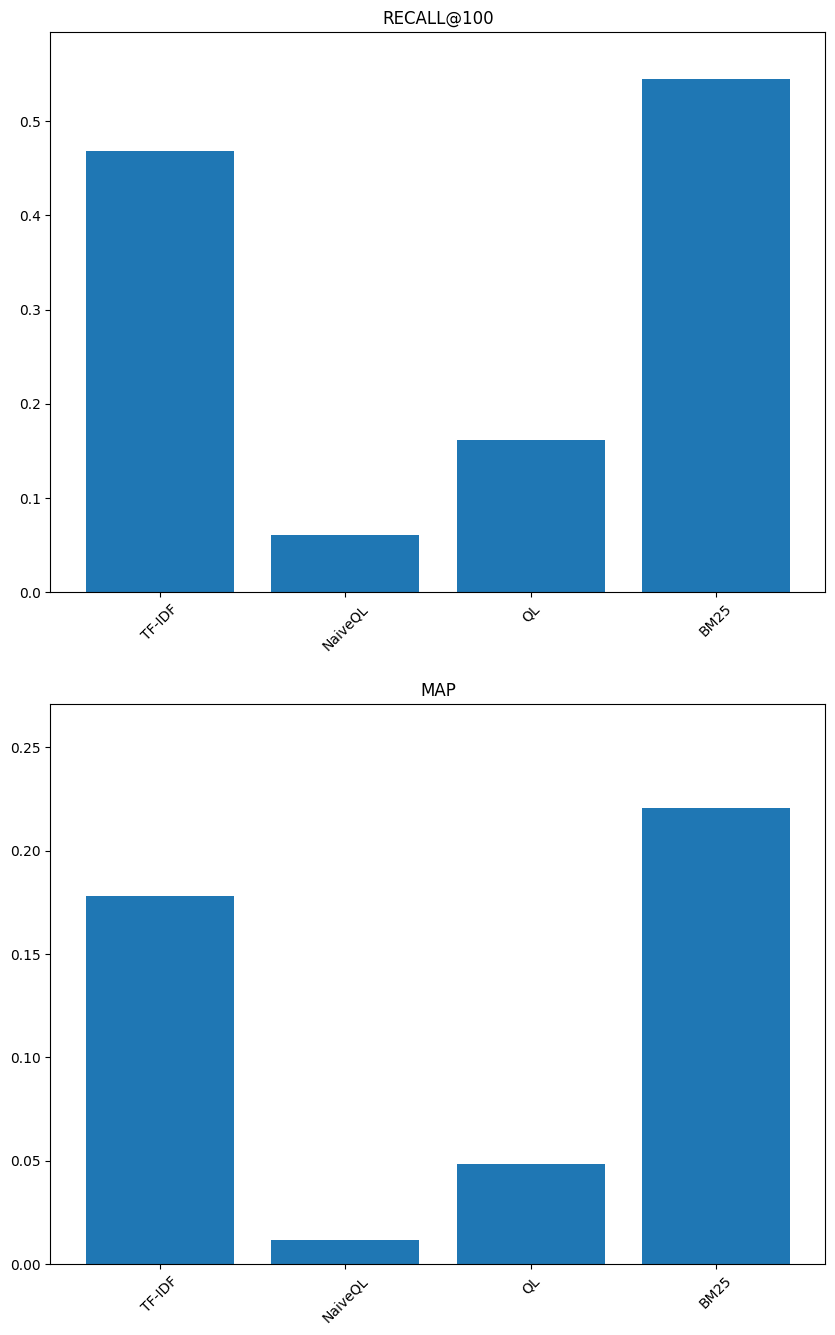

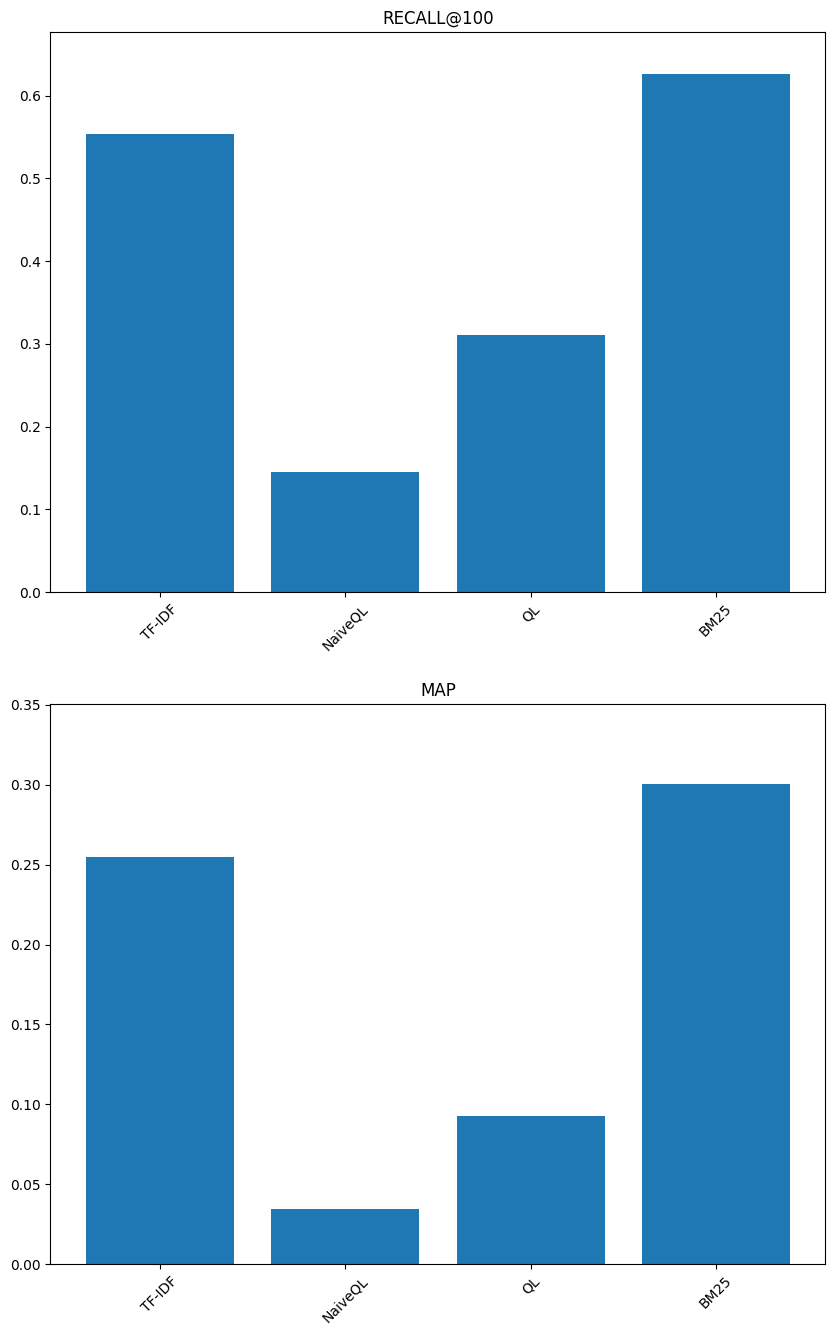

In [39]:
results = {}
index_sets = {1: dh1, 2: dh2}

for index_set, dh in index_sets.items():
    results[index_set] = {}
    print(f"Index: {index_set}")
    for search_fn_name, search_fn in list_of_search_fns:
        print(f"\tEvaluating Search Function: {search_fn_name}")
        results[index_set][search_fn_name] = evaluate_search_fn(search_fn_name, search_fn, list_of_metrics, dh, queries, qrels, index_set)
        for metric_name, metric_val in results[index_set][search_fn_name].items():
            print(f"\t\tMetric: {metric_name}: {metric_val:0.4f}")
        print()

def plot_metrics(search_fns):

    fig, axes = plt.subplots(nrows=len(list_of_metrics), ncols=1)
    fig.set_figheight(8 * len(list_of_metrics))
    fig.set_figwidth(10)

    for (metric, _), ax in zip(list_of_metrics, axes):
        metrics = []
        labels = []
        for search_fn in search_fns:
            metrics.append(search_fns[search_fn][metric])
            labels.append(search_fn)

        x = np.arange(len(labels))
        rects = ax.bar(x, metrics, label=metric)

        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45)
        ax.set_ylim(ymin=0, ymax= max(metrics) + 0.05)
        ax.set_title(metric)

plot_metrics(results[1])

plot_metrics(results[2])


In [40]:
# Check document lengts
lengths = dh.get_doc_lengths().values()

min(lengths), max(lengths), lengths


(1,
 243,
 dict_values([6, 6, 5, 5, 4, 3, 5, 4, 2, 5, 10, 6, 5, 11, 4, 5, 3, 4, 5, 25, 4, 8, 9, 4, 4, 4, 6, 3, 2, 8, 5, 8, 7, 3, 6, 7, 3, 3, 23, 116, 5, 5, 4, 6, 6, 58, 5, 116, 8, 7, 4, 13, 4, 6, 2, 5, 7, 54, 18, 6, 5, 8, 44, 4, 6, 6, 4, 73, 17, 22, 90, 3, 4, 5, 5, 9, 3, 68, 6, 9, 5, 22, 5, 23, 5, 16, 8, 10, 8, 8, 4, 45, 16, 17, 56, 45, 8, 9, 4, 7, 3, 4, 72, 68, 5, 73, 3, 5, 3, 2, 48, 8, 4, 4, 3, 43, 6, 4, 3, 5, 4, 6, 59, 30, 6, 8, 5, 6, 6, 8, 10, 6, 9, 9, 5, 3, 6, 8, 6, 6, 3, 3, 14, 85, 4, 48, 6, 5, 10, 8, 5, 6, 3, 5, 2, 5, 5, 6, 5, 6, 6, 3, 3, 4, 4, 7, 6, 9, 3, 5, 6, 7, 5, 9, 9, 7, 19, 4, 10, 10, 10, 10, 4, 8, 71, 8, 2, 6, 4, 4, 3, 4, 4, 6, 2, 5, 3, 7, 6, 9, 9, 43, 4, 4, 34, 3, 4, 4, 4, 8, 5, 6, 4, 5, 7, 4, 5, 4, 3, 5, 4, 22, 3, 51, 7, 11, 5, 5, 2, 4, 5, 5, 6, 6, 2, 28, 7, 4, 6, 5, 53, 27, 110, 7, 9, 9, 7, 47, 9, 6, 37, 49, 10, 58, 5, 7, 5, 6, 5, 6, 2, 1, 5, 4, 44, 4, 5, 5, 4, 4, 8, 39, 4, 10, 6, 39, 6, 103, 4, 5, 29, 74, 3, 73, 3, 5, 4, 4, 7, 6, 3, 5, 8, 3, 6, 4, 5, 72, 4, 33, 7, 5,

---
#### 5.3.1 Summary
Write a summary of what you observe in the results.
Your summary should compare results across the 2 indices and the methods being used. State what you expected to see in the results, followed by either supporting evidence *or* justify why the results did not support your expectations.

*Submission format:*

1- Your runtime evaluation results of the given list of metrics and search functions
  will be saved in separate files as follows (Make sure the contents of these files are as expected and not damaged due to
  any errors):

2- You need to submit your response including up to 250 words in a file named as: `analysis.md` (with markdown format) in
the root directory of your repository. Your file should also include a table of your results with following shape:

| Ranking Algorithm | Index      | RECALL@100  | MAP         |
|-------------------|------------|-------------|-------------|
|       Tf-IDF      | 1 <br> 2   |   x <br> x  |   x <br> x  |
|       Naive-QL    | 1 <br> 2   |   x <br> x  |   x <br> x  |
|       QL          | 1 <br> 2   |   x <br> x  |   x <br> x  |
|       BM25        | 1 <br> 2   |   x <br> x  |   x <br> x  |



### Summary

Preprocessing the text makes the queries more effective. Stemming reduces words to their base or root form, removing stopwords eliminates filler words, and lowercasing ensures that the same words are treated identically. This is expected to improve ranking.

- Naive-QL is a probabilistic method that ranks documents based on the likelihood of a query being generated from each document's language model. It requires consistent and well-represented documents and can effectively handle rare terms. However, it is basic and is expected to perform poorly due to zero-frequency problems with some documents.
- QL operates similarly to Naive-QL but uses smoothing to handle terms that do not appear in some documents. It is expected to perform better than Naive-QL.
- TF-IDF uses keywords and calculates term frequencies to determine scores. It is more robust with diverse document contents than the first two methods. However, it does not consider the length of the documents and term saturation.
- BM25 is more sophisticated than TF-IDF and addresses these issues. It is expected to perform better in this case, as the number of tokens per document varies significantly.

The expectations are confirmed by the table below. Preprocessing significantly improves ranking performance, especially with respect to the mean average precision metric. BM25 search performs the best, and Naive-QL performs the worst. We notice that ranking by keywords using TF-IDF search is much better than the probabilistic QL method, which can be attributed to poorly represented documents.

| Ranking Algorithm | Index      | RECALL@100  | MAP         |
|-------------------|------------|-------------|-------------|
|       Tf-IDF      | 1 <br> 2   |   0.4682 <br> 0.5530  |   0.1781 <br> 0.2548  |
|       Naive-QL    | 1 <br> 2   |   0.0608 <br> 0.1456  |   0.0117 <br> 0.0347  |
|       QL          | 1 <br> 2   |   0.1611 <br> 0.3108  |   0.0483 <br> 0.0927  |
|       BM25        | 1 <br> 2   |   0.5446 <br> 0.6265  |   0.2209 <br> 0.3004  |
